In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from procedures import create_binance_bot, create_binance_bot_spot, make_get_filepath
from pure_funcs import get_template_live_config, ts_to_date, get_daily_from_income
from njit_funcs import round_dynamic
from time import time, sleep
import os
import pandas as pd
import asyncio
import numpy as np
import matplotlib.pyplot as plt

using numba


In [3]:
plt.rcParams["figure.figsize"] = [21, 13]
pd.set_option("display.precision", 10)

In [4]:
config = get_template_live_config()
config["symbol"] = "XMRUSDT"  # dummy symbol
config["exchange"] = "binance"
config["market_type"] = "futures"
config["user"] = "binance_01"
try:
    await bot.session.close()
except:
    pass
if config["market_type"] == "spot":
    bot = await create_binance_bot_spot(config)
else:
    bot = await create_binance_bot(config)

not using numba
not using numba
not using numba
linear perpetual
initiating position, open orders, fills, exchange config, order book, and emas...
2023-04-06T08:41:36  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
2023-04-06T08:41:36  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
2023-04-06T08:41:38  {'code': -2015, 'msg': 'Invalid API-key, IP, or permissions for action'} 
done


In [5]:
info = await bot.public_get(bot.endpoints["exchange_info"])
csvs = {}
syms = [x["symbol"] for x in info["symbols"] if x["symbol"].endswith("USDT")]
n = 7
interval = "5m"
while True:
    if not syms:
        break
    subset = syms[:n]
    syms = syms[n:]
    res = await asyncio.gather(*[bot.fetch_ohlcvs(symbol=s, interval=interval) for s in subset])
    for s, r in zip(subset, res):
        csvs[s] = pd.DataFrame(r)
    print(subset, len(syms))

['BTCUSDT', 'ETHUSDT', 'BCHUSDT', 'XRPUSDT', 'EOSUSDT', 'LTCUSDT', 'TRXUSDT'] 175
['ETCUSDT', 'LINKUSDT', 'XLMUSDT', 'ADAUSDT', 'XMRUSDT', 'DASHUSDT', 'ZECUSDT'] 168
['XTZUSDT', 'BNBUSDT', 'ATOMUSDT', 'ONTUSDT', 'IOTAUSDT', 'BATUSDT', 'VETUSDT'] 161
['NEOUSDT', 'QTUMUSDT', 'IOSTUSDT', 'THETAUSDT', 'ALGOUSDT', 'ZILUSDT', 'KNCUSDT'] 154
['ZRXUSDT', 'COMPUSDT', 'OMGUSDT', 'DOGEUSDT', 'SXPUSDT', 'KAVAUSDT', 'BANDUSDT'] 147
['RLCUSDT', 'WAVESUSDT', 'MKRUSDT', 'SNXUSDT', 'DOTUSDT', 'DEFIUSDT', 'YFIUSDT'] 140
['BALUSDT', 'CRVUSDT', 'TRBUSDT', 'RUNEUSDT', 'SUSHIUSDT', 'SRMUSDT', 'EGLDUSDT'] 133
['SOLUSDT', 'ICXUSDT', 'STORJUSDT', 'BLZUSDT', 'UNIUSDT', 'AVAXUSDT', 'FTMUSDT'] 126
['HNTUSDT', 'ENJUSDT', 'FLMUSDT', 'TOMOUSDT', 'RENUSDT', 'KSMUSDT', 'NEARUSDT'] 119
['AAVEUSDT', 'FILUSDT', 'RSRUSDT', 'LRCUSDT', 'MATICUSDT', 'OCEANUSDT', 'CVCUSDT'] 112
['BELUSDT', 'CTKUSDT', 'AXSUSDT', 'ALPHAUSDT', 'ZENUSDT', 'SKLUSDT', 'GRTUSDT'] 105
['1INCHUSDT', 'CHZUSDT', 'SANDUSDT', 'ANKRUSDT', 'BTSUSDT', 'LITUS

In [6]:
def correlation(x, y):
    x_mean = x.mean()
    y_mean = y.mean()
    a = x - x_mean
    b = y - y_mean
    return ((a * b).sum()) / (((a ** 2).sum() * (b ** 2).sum()) ** 0.5)

In [7]:
n_symbols = 30
vols = [(csvs[s].volume * csvs[s].close).sum() for s in csvs]
minvol = sorted(vols)[-n_symbols]
ss = [s for s in csvs if (csvs[s].volume * csvs[s].close).sum() >= minvol]
corrs = []
corrs_dict = {}
done = set()
for s0 in sorted(ss):
    for s1 in sorted(ss):
        if s0 == s1:
            continue
        key = tuple(sorted([s0, s1]))
        if key in done:
            continue
        done.add(key)
        x = csvs[s0].close
        y = csvs[s1].close
        corr = correlation(x, y)
        print(f"\r{s0} {s1} {corr:.4f}      ", end=" ")
        corrs.append((corr,) + key)

corrs_dict = {}
corrs_dict_abs = {}
for e in corrs:
    if e[1] not in corrs_dict:
        corrs_dict[e[1]] = {e[2]: e[0]}
        corrs_dict_abs[e[1]] = {e[2]: abs(e[0])}

    else:
        corrs_dict[e[1]][e[2]] = e[0]
        corrs_dict_abs[e[1]][e[2]] = abs(e[0])

    if e[2] not in corrs_dict:
        corrs_dict[e[2]] = {e[1]: e[0]}
        corrs_dict_abs[e[2]] = {e[1]: abs(e[0])}

    else:
        corrs_dict[e[2]][e[1]] = e[0]
        corrs_dict_abs[e[2]][e[1]] = abs(e[0])

XRPUSDT ZRXUSDT -0.1216             

In [8]:
# sum correlation of each symbol to every other symbol
corr_sorted = sorted([(sum(corrs_dict[s].values()), s) for s in corrs_dict])
corr_sorted

[(-0.04735599750101806, 'APTUSDT'),
 (0.5529247898495714, 'XRPUSDT'),
 (1.3105338942392817, 'SXPUSDT'),
 (2.578710053987252, 'INJUSDT'),
 (4.349194213180767, 'MASKUSDT'),
 (5.7900070230100225, 'C98USDT'),
 (6.170174762557025, 'APEUSDT'),
 (7.647911197732388, 'DOGEUSDT'),
 (8.507463295852013, 'ANKRUSDT'),
 (9.579903180264681, 'CFXUSDT'),
 (9.819490282412318, 'LINAUSDT'),
 (10.58851617145616, 'ARBUSDT'),
 (10.847878754344677, 'BNBUSDT'),
 (10.951115215913077, '1000SHIBUSDT'),
 (11.332761001971967, 'ICXUSDT'),
 (12.271009593626367, 'ADAUSDT'),
 (12.73600012635441, 'DOTUSDT'),
 (12.870552212229052, 'LINKUSDT'),
 (13.008538451276149, 'DYDXUSDT'),
 (13.105623829169227, 'LTCUSDT'),
 (13.419335166969436, 'BTCUSDT'),
 (13.528333648673218, 'LDOUSDT'),
 (13.979011935849044, 'ZRXUSDT'),
 (14.0262092813709, 'ETHUSDT'),
 (14.446555216254534, 'FTMUSDT'),
 (14.704002995334491, 'FILUSDT'),
 (15.249711424697729, 'ETCUSDT'),
 (15.46220345315908, 'OPUSDT'),
 (15.48987987875503, 'SOLUSDT'),
 (15.6502517731

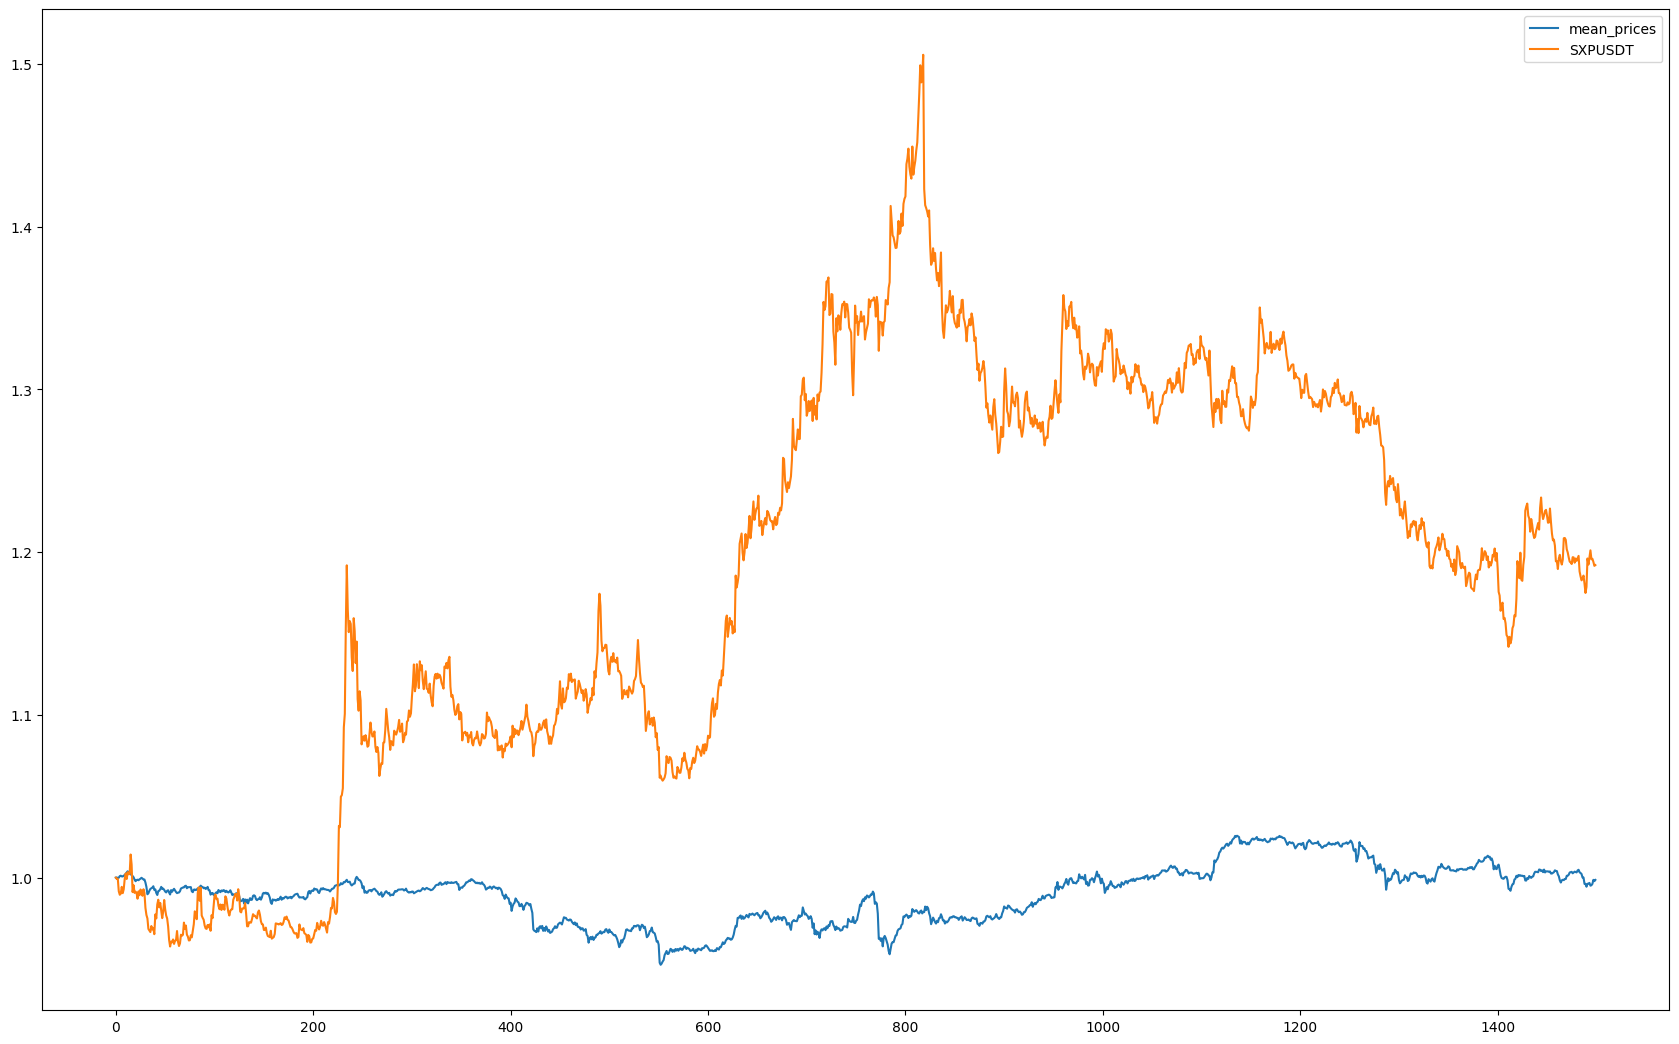

In [9]:
# mean of all symbol
mean_prices = pd.concat([e.close / e.close.iloc[0] for e in csvs.values()], axis=1).mean(axis=1)

# compare individual symbol to mean
symbol = "SXPUSDT"
# symbol = corr_sorted[0][1]  # least correlated symbol
mean_prices.rename("mean_prices").plot()
(csvs[symbol].close / csvs[symbol].close.iloc[0]).rename(symbol).plot()
plt.legend()

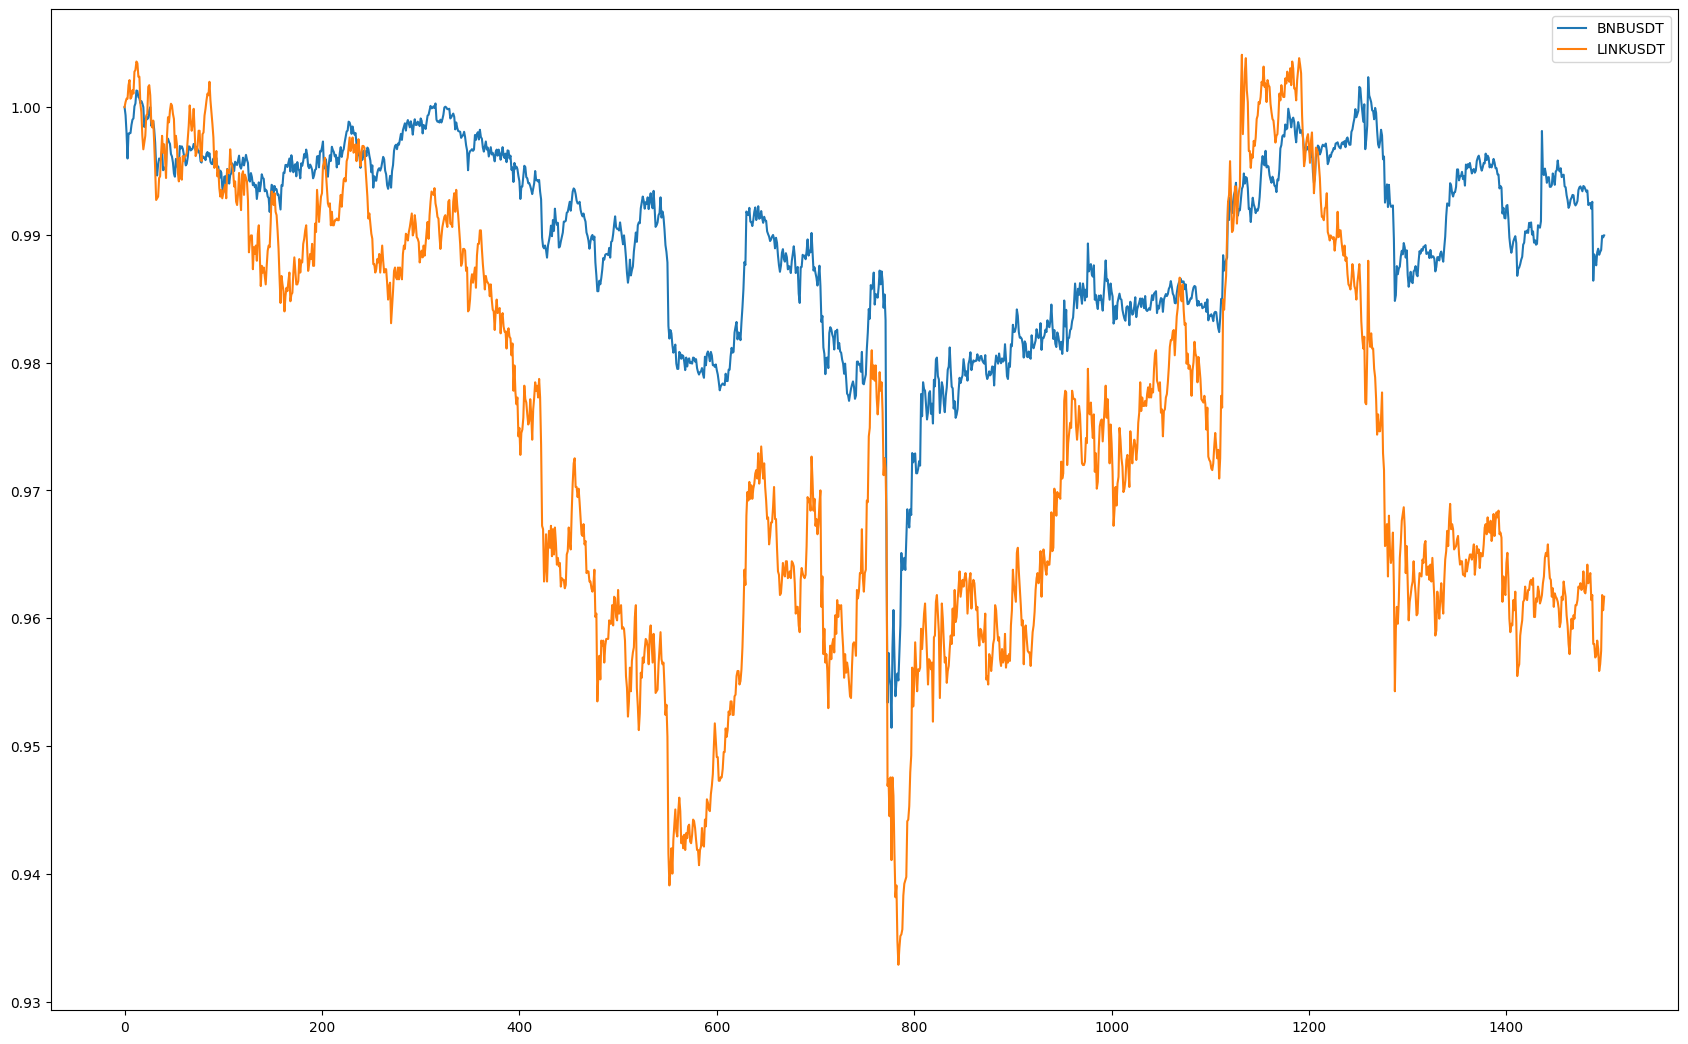

In [10]:
# compare two symbols
symbol0 = "BNBUSDT"
symbol1 = "LINKUSDT"
(csvs[symbol0].close / csvs[symbol0].close.iloc[0]).rename(symbol0).plot()
(csvs[symbol1].close / csvs[symbol1].close.iloc[0]).rename(symbol1).plot()
plt.legend()